## Required functions

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram

In [2]:
from qiskit import execute, BasicAer
def simulate(circuit, shots=1024, x="0", verbose=False):
    names = []
    regs = []
    for q in circuit.qubits:
        name = q.register.name
        size = len(q.register)
        if name not in names:
            names.append(name)
            regs.append(size)

    if verbose: print(names, regs)

    #assuming that we only have 2: control + anciallary
    qra = QuantumRegister(regs[0], name=names[0])
    if len(regs) > 1:
        qran = QuantumRegister(regs[1], name=names[1])
        qa = QuantumCircuit(qra,qran)
    else:
        qa = QuantumCircuit(qra)

    if len(x) != sum(regs): x += "0" * (sum(regs) - len(x))
    x = x[::-1]
    if verbose: print(x)
    for bit in range(len(x)):
        if verbose: print(x[bit], type(x[bit]))
        if x[bit] != "0":
            qa.x(bit)
    qa.barrier()

    qa.extend(circuit)

    if verbose:
        print(qa)

    backend = BasicAer.get_backend('qasm_simulator')
    results = execute(qa, backend=backend, shots=shots).result()
    answer = results.get_counts()
    return answer

In [3]:
def create_random_circuit(n,k, measure=True):
    qc = QuantumCircuit(n)
    for i in range(k):
        if random.random() < 0.25:
            qc.x(i%n)
        if random.random() < 0.25:
            qc.y(i%n)
        if random.random() < 0.25:
            qc.z(i%n)
        if random.random() < 0.25:
            qc.h(i%n)
        if n > 1 and random.random() < 0.25:
            a = i%n
            b = random.randint(0,n-1)
            while b == a: a = random.randint(0,n-1)
            qc.cx(a, b)

    if measure: qc.measure_all()
        
    return qc

In [4]:
import random
def randomly_measure(qc, p=0.25):
    qc = qc.copy()
    qc.remove_final_measurements()
    n = qc.num_qubits
    qc2 = QuantumCircuit(n)
    #qc2.add_register(cregs)
    cregs = [ClassicalRegister(1, name="c" + str(i)) for i in range(n)]
    [qc2.add_register(cregs[i]) for i in range(n)]
    
    #iterate through circuit
    for op in qc.data:
        
        qc2.data.append(op)
    
        if random.random() < p:
            #print("interrupting")
            qc2.barrier()
            for i in range(n):
                qc2.measure(i, cregs[i])
                qc2.reset(i)
                qc2.x(i).c_if(cregs[i], 1)
            qc2.barrier()

    qc2.barrier()
    [qc2.measure(i, cregs[i]) for i in range(n)]
    
    return qc2

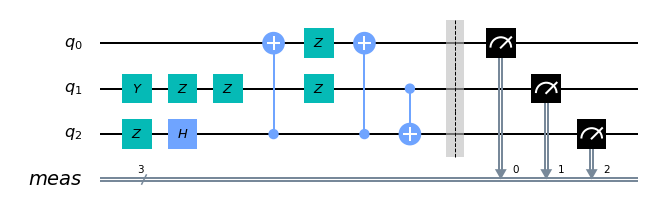

In [5]:
qrand = create_random_circuit(3,8)
qrand.draw(output='mpl')

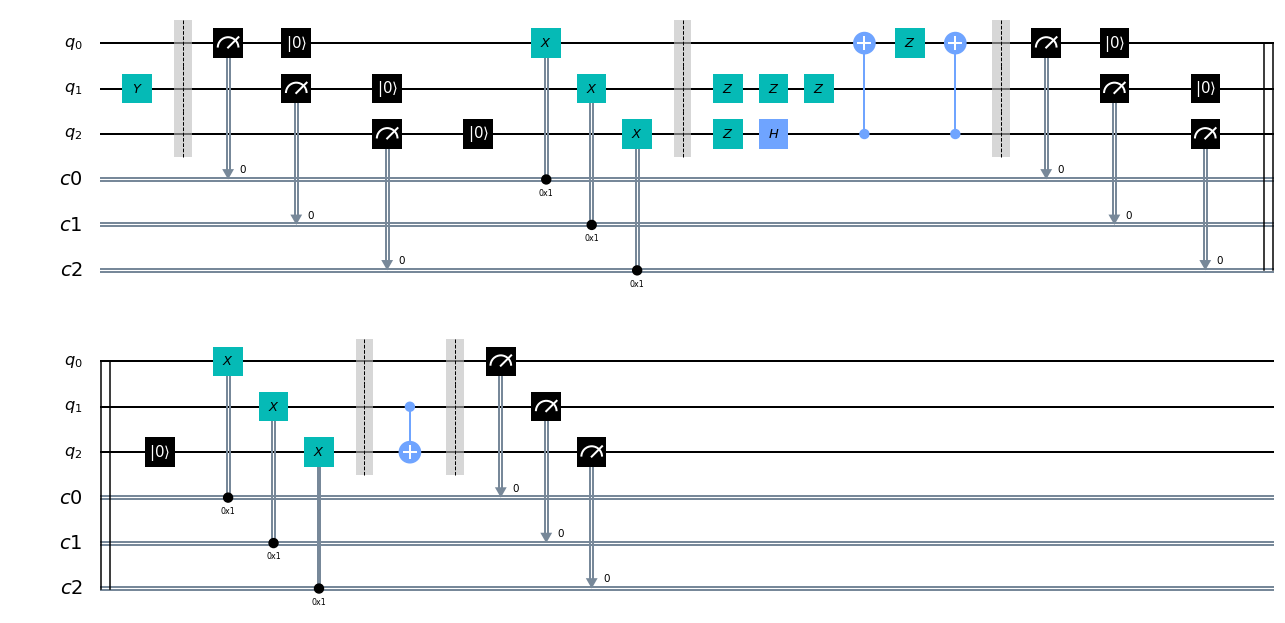

In [6]:
qc = randomly_measure(qrand, p=0.25)
qc.draw(output='mpl')

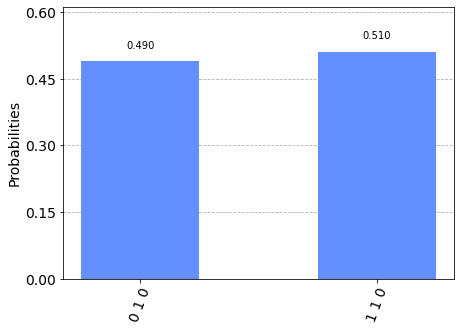

In [7]:
plot_histogram(simulate(qc))

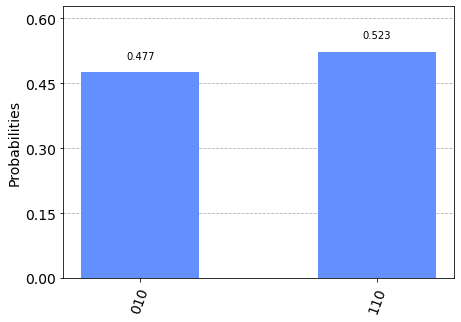

In [8]:
plot_histogram(simulate(qrand))

In [9]:
n = 3

sames = []
diffs = []
print("testing circuits... (quite slow)")
for j in range(1,16):
    qrand = create_random_circuit(n,j)
    qc = randomly_measure(qrand, p=0.25)
    a,b = simulate(qc), simulate(qrand)
    if len(a) == len(b):
        assert random.choice(list(a.keys())).replace(" ", "") in b.keys(), (a, b) #reduces, not eliminates, the chance they're different
        sames.append((qrand, qc))
    else:
        diffs.append((qrand, qc))
print("n =", n, ": ", len(sames), "same", len(diffs), "different")

testing circuits... (quite slow)
n = 3 :  12 same 3 different


same:
circuits of lengths:  [5, 5, 8, 8, 6, 12, 14, 11, 12, 13, 21, 19]


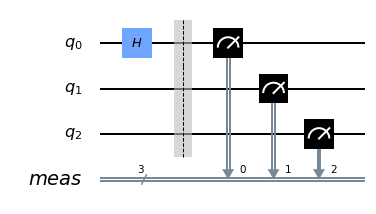

In [10]:
print("same:")
print("circuits of lengths: ", [len(c[0]) for c in sames])
random.choice(sames)[0].draw(output='mpl')

circuits of lengths:  [25, 16, 25]
different:


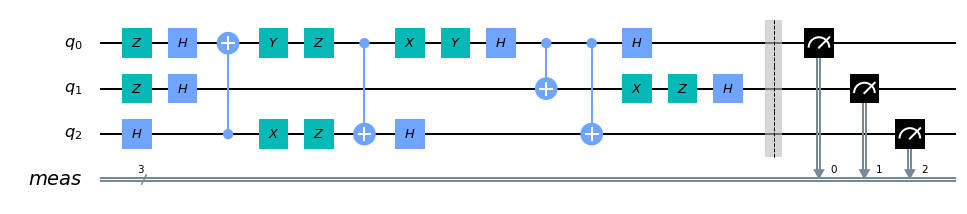

In [11]:
assert len(diffs) > 0, "no circuits that are different" 
print("circuits of lengths: ", [len(c[0]) for c in diffs])
print("different:")
random.choice(diffs)[0].draw(output='mpl')

16


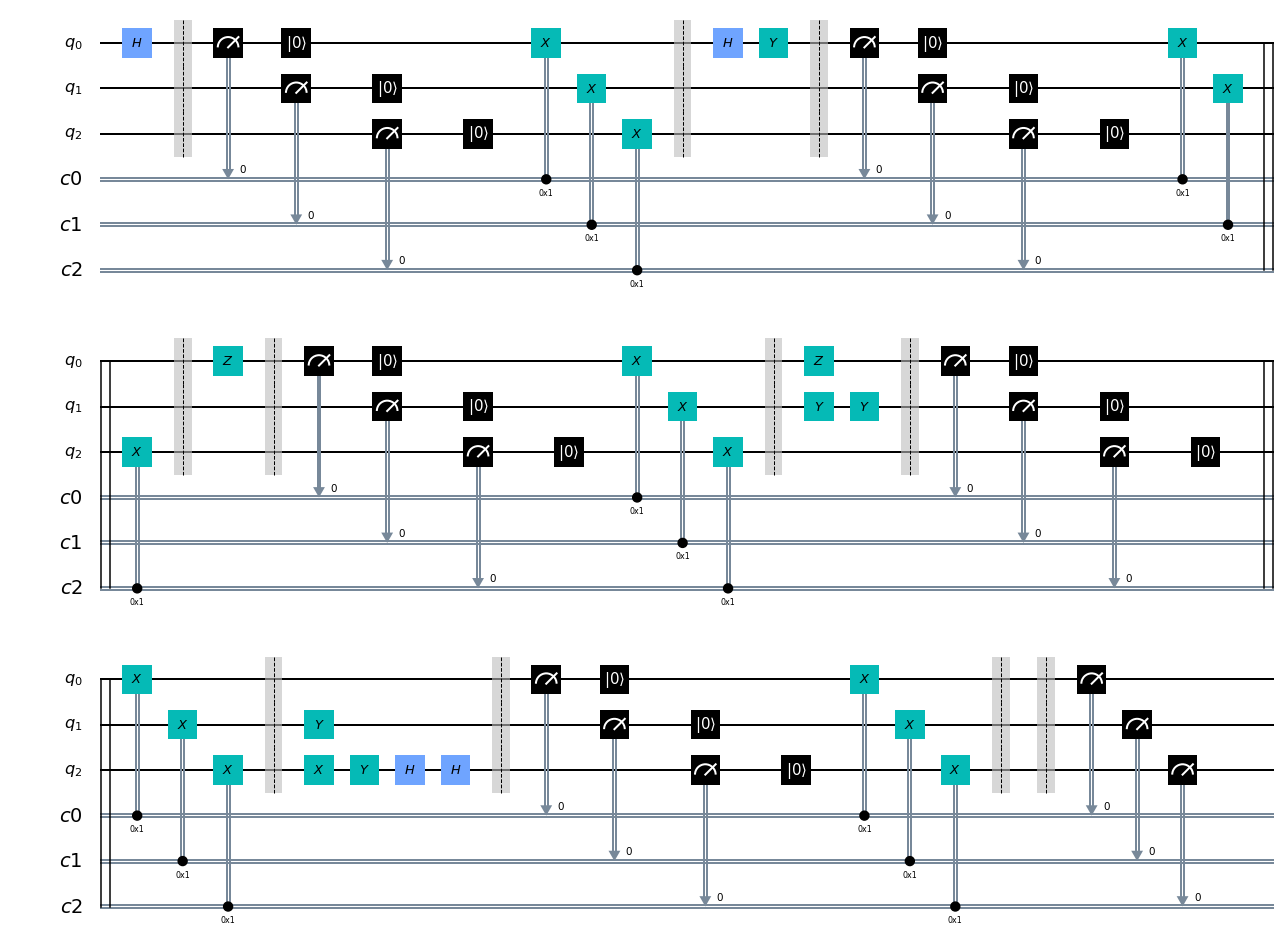

In [12]:
print(len(diffs[1][0]))
diffs[1][1].draw(output='mpl')

## Test your own circuit

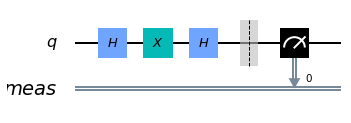

In [13]:
qc = QuantumCircuit(1)
qc.h(0)
qc.x(0)
qc.h(0)
qc.measure_all()
qc.draw(output='mpl')

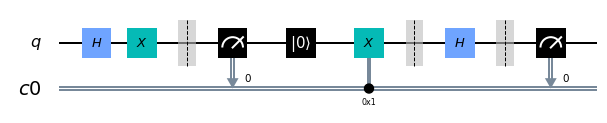

In [17]:
qc2 = randomly_measure(qc, p=0.5)
qc2.draw(output='mpl')

In [18]:
a, b = simulate(qc), simulate(qc2)
len(a) == len(b)

False

In [19]:
a, b

({'0': 1024}, {'0': 488, '1': 536})

In [21]:
simulate(qc, x="1")

{'1': 1024}